In [1]:
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
from tqdm import tqdm
from typing import Callable, Iterable, Tuple, Union, List

### Rhombhus Dist: X + Y <= 1

In [2]:
rhombus_fn = lambda x, y: 0.5 * ((np.abs(x) + np.abs(y)) <= 1)
init_sample = (0, 0)
n_samples = 10_000
rand_step = lambda x: x + (np.random.rand() - 0.5)
proposal_sampler = lambda x, y: (rand_step(x), rand_step(y))

Markov Chain Monte Carlo Acceptance Criteria:

$$p = \min\left(1, \frac{p(x_{new})}{p(x_{prev})}\right)$$


MCMC Metropolis-Hastings Acceptance Criteria:
$$\alpha = \min\left(1, \frac{p(x_{new}) \cdot q(x_{prev}|x_{new})}{p(x_{prev}) \cdot q(x_{new}|x_{prev})}\right)$$

In [3]:
def metropolis_hastings_accept_ratio(
        sample_new,
        sample_prev,
        target_pdf: Callable,
        proposal_pdf: Callable
    ) -> float:
    p_prev = target_pdf(sample_prev)
    p_new = target_pdf(sample_new)

    q_prev = proposal_pdf(sample_prev, sample_new) # q(init | sample)
    q_new = proposal_pdf(sample_new, sample_prev) # q(sample | init)

    return (p_new * q_prev) / (p_prev * q_new) 


def generate_single_sample_mcmc(
        init_sample,
        proposal_sampler: Callable,
        target_pdf: Callable,
        proposal_pdf: Callable=None
    ) -> Tuple[Iterable, bool]:
    init_sample = tuple(np.atleast_1d(init_sample))
    sample = tuple(np.atleast_1d(proposal_sampler(*init_sample)))
    if proposal_pdf:
        accept_ratio = metropolis_hastings_accept_ratio(sample, init_sample, target_pdf, proposal_pdf)
    else:
        accept_ratio = target_pdf(*sample) / target_pdf(*init_sample)
    repeat = False

    if accept_ratio < np.random.rand():
        sample = init_sample
        repeat = True
    
    return sample, repeat


def generate_samples_mcmc(
        n_samples,
        init_sample,
        proposal_sampler: Callable,
        target_pdf: Callable,
        proposal_pdf: Callable=None
    ) -> Tuple[Iterable, float]:
    samples = []
    repeats = 0
    prev_sample = init_sample

    for _ in tqdm(range(n_samples), total=n_samples):
        sample, repeat = generate_single_sample_mcmc(prev_sample, proposal_sampler, target_pdf, proposal_pdf)
        if sample == prev_sample:
            repeats += repeat
        samples.append(sample)
        prev_sample = samples[-1]

    repeats_freq = repeats/n_samples
    return samples, repeats_freq

In [4]:
samples, repeats_freq = generate_samples_mcmc(n_samples, init_sample, proposal_sampler, rhombus_fn)

100%|██████████| 10000/10000 [00:00<00:00, 157937.70it/s]


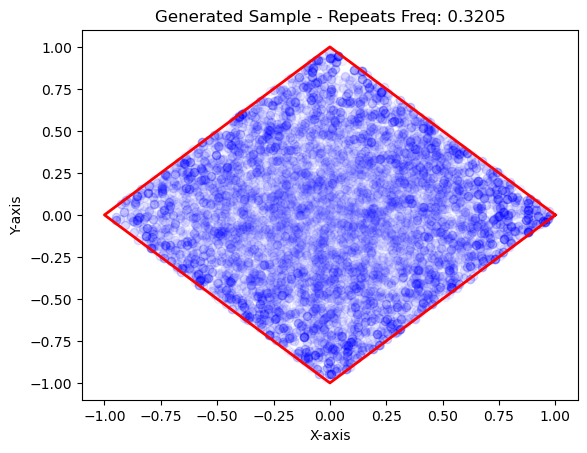

In [5]:
samples = np.array(samples)
samples_x, samples_y = samples[:,0], samples[:,1]

# Coordinates of the rhombus vertices
x = [1, 0, -1, 0, 1]
y = [0, 1, 0, -1, 0]

# Plot the rhombus edges
plt.plot(x, y, 'r-', linewidth=2)
plt.scatter(samples_x, samples_y, color='blue', marker='o', alpha=0.05)

# Add labels and title
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title(f'Generated Sample - Repeats Freq: {repeats_freq}')

# Show plot
plt.show()

### Gaussian Mixture Distribution

Gaussian Mixture pdf function:
$$f(x) = \sum_{i=1}^{k} w_i \cdot \mathcal{N}(x; \mu_i, \sigma_i^2)$$

In [6]:
weights = [0.3, 0.7]
gaussians = [(3,1.5), (-1,1)]

def gaussian_mixture_pdf(
   x: Union[float, np.ndarray], 
   weights: List[float], 
   gaussians: List[Tuple[float, float]]
) -> Union[float, np.ndarray]:
    """
    Compute the probability density function of a Gaussian mixture model.

    Parameters
    ----------
    x : Union[float, np.ndarray]
        Input values where the PDF is evaluated. Can be a scalar or array.
    weights : List[float]
        Mixture weights for each Gaussian component. Must sum to 1.
    gaussians : List[Tuple[float, float]]
        List of (mean, std_dev) tuples defining each Gaussian component.
        Each tuple contains (loc, scale) parameters for scipy.stats.norm.

    Returns
    -------
    Union[float, np.ndarray]
        PDF values at input points x. Returns scalar if x is scalar,
        otherwise returns array of same shape as x.
    """
    x_array = np.atleast_1d(x)
    
    pdf = np.zeros(len(x_array))
    for w, (loc, scale) in zip(weights, gaussians):
        pdf += w * st.norm.pdf(x_array, loc=loc, scale=scale)
    
    return pdf[0] if np.isscalar(x) else pdf

Using the following proposal sampler:

\begin{align}
x' &\sim \mathcal{N}(x, 0.5^2) \quad \text{(Normal μ=x, σ=0.5)} \\
x' &\sim \mathcal{N}(x, 1^2) \quad \text{(Normal μ=x, σ=1)} \\
x' &\sim \mathcal{N}(x, 1.5^2) \quad \text{(Normal μ=x, σ=1.5)} \\
x' &\sim \mathcal{U}(x-0.5, x+0.5) \quad \text{(Uniform ±0.5)} \\
x' &\sim \mathcal{U}(x-1, x+1) \quad \text{(Uniform ±1)} \\
x' &\sim \mathcal{U}(x-1.5, x+1.5) \quad \text{(Uniform ±1.5)}
\end{align}

In [7]:
n_samples = 10_000
target_pdf = lambda x: gaussian_mixture_pdf(x, weights, gaussians)
samples_groups = []
samples_groups_freq = []
proposed_dists = {
    'normal (σ=0.5)': {'proposal_sampler': lambda x: np.random.normal(x, 0.5)},
    'normal (σ=1)': {'proposal_sampler': lambda x: np.random.normal(x, 1)},
    'normal (σ=1.5)': {'proposal_sampler': lambda x: np.random.normal(x, 1.5)},
    'uniform (±0.5)': {'proposal_sampler': lambda x: np.random.uniform(x-0.5, x+0.5)},
    'uniform (±1)': {'proposal_sampler': lambda x: np.random.uniform(x-1, x+1)},
    'uniform (±1.5)': {'proposal_sampler': lambda x: np.random.uniform(x-1.5, x+1.5)},
}
for proposal_dist_name, proposal_dist_info in proposed_dists.items():
    proposal_sampler = proposal_dist_info['proposal_sampler']
    samples, repeats_freq = generate_samples_mcmc(n_samples, (0, ), proposal_sampler, target_pdf)
    proposal_dist_info['generated_samples'] = np.array(samples)[:,0]
    proposal_dist_info['repeats_freq'] = repeats_freq

100%|██████████| 10000/10000 [00:01<00:00, 7411.14it/s]


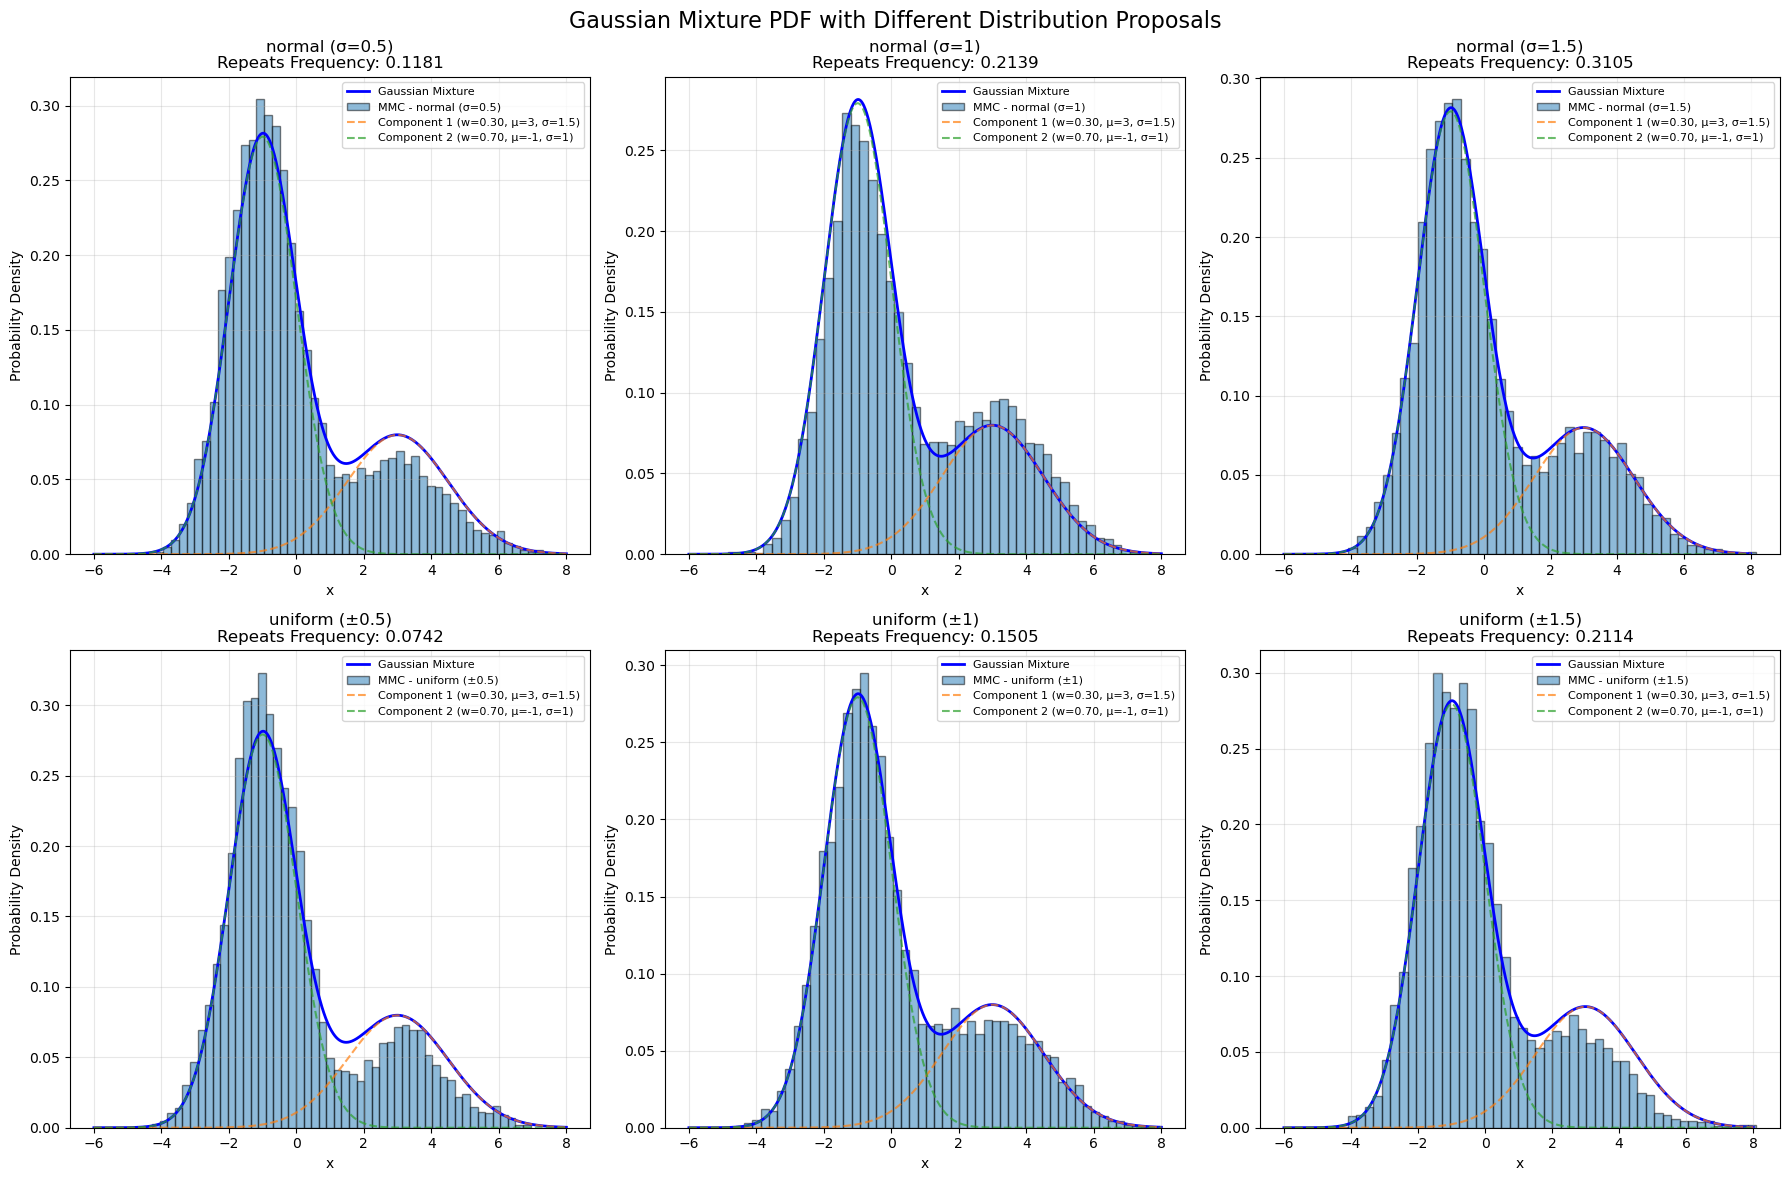

In [8]:
# Create x target pdf values for plotting
x_vals = np.linspace(-6, 8, 1000)
pdf_vals = gaussian_mixture_pdf(x_vals, weights, gaussians)

# Plot the mixture
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, (proposal_dist_name, proposal_dist_info) in enumerate(proposed_dists.items()):
    ax = axes[idx]
    
    # Plot the Gaussian mixture
    ax.plot(x_vals, pdf_vals, 'b-', linewidth=2, label='Gaussian Mixture')
    
    # Get samples and frequency info
    samples = proposal_dist_info['generated_samples']
    repeats_freq = proposal_dist_info['repeats_freq']
    
    # Plot histogram of samples
    ax.hist(samples, bins=50, density=True, alpha=0.5, 
            label=f'MMC - {proposal_dist_name}', edgecolor='black')
    
    # Plot individual components
    for comp_idx, (w, (loc, scale)) in enumerate(zip(weights, gaussians)):
        component_pdf = w * st.norm.pdf(x_vals, loc=loc, scale=scale)
        ax.plot(x_vals, component_pdf, '--', alpha=0.7, 
                label=f'Component {comp_idx+1} (w={w:.2f}, μ={loc}, σ={scale})')
    
    
    # Set labels and title for each subplot
    ax.set_xlabel('x')
    ax.set_ylabel('Probability Density')
    ax.set_title(f'{proposal_dist_name}\nRepeats Frequency: {repeats_freq}')
    
    # Add legend to each subplot
    ax.legend(loc='upper right', fontsize=8)
    ax.grid(True, alpha=0.3)

# Add overall title
fig.suptitle('Gaussian Mixture PDF with Different Distribution Proposals', fontsize=16, y=0.98)
plt.subplots_adjust(top=0.93)

plt.tight_layout()
plt.show()

Next we are testing a different approach using a mixture of uniform distributions:

$$f(x) = \sum_{i=1}^{k} w_i \cdot \mathcal{U}(x; a_i, b_i)$$

Specifically, this proposal distribution combines 2 components: a local window around the current state and a global range:

$$f(x_{new}|x_{prev}) = w_{local} \cdot \mathcal{U}(x_{new}; x_{prev} - h, x_{prev} + h) + w_{global} \cdot \mathcal{U}(x_{new}; a_{global}, b_{global})$$

where $w_{local} + w_{global} = 1$, $h$ is the local window half-width, and $[a_{global}, b_{global}]$ defines the global range.

As this proposal distribution is not symmetric $(p_{proposal}(x_{new}|x_{prev}) \neq p_{proposal}(x_{prev}|x_{new}))$, we will use the Metropolis-Hastings algorithm with acceptance probability:

$$\alpha = \min\left(1, \frac{p(x_{new}) \cdot q(x_{prev}|x_{new})}{p(x_{prev}) \cdot q(x_{new}|x_{prev})}\right)$$

Note: $ q = p_{proposal} $

In [9]:
def uniform_mixture_sampler(
        weights: Iterable[float],
        ranges: Iterable[Tuple[float, float]]
    ) -> float:
    rand = np.random.rand()
    cum_weights = np.cumsum(weights)
    selected_dist_idx = np.searchsorted(cum_weights, rand)
    low, high = ranges[selected_dist_idx]
    
    return np.random.uniform(low, high)


def local_global_uniform_sampler(
        x: float,
        local_weight: float,
        local_window_size: float,
        global_range: Tuple[float, float]
    ) -> float:
    weights = [local_weight, 1-local_weight]
    ranges = [(x - local_window_size, x + local_window_size), global_range]
    return uniform_mixture_sampler(weights, ranges)


def uniform_mixture_pdf(
        x: float,
        weights: Iterable[float],
        ranges: Iterable[Tuple[float, float]]
    ) -> Union[float, np.ndarray]:
    x_array = np.atleast_1d(x)
    
    pdf = np.zeros(len(x_array))
    for w, (low, high) in zip(weights, ranges):
        pdf += w * st.uniform.pdf(x_array, low, high)
    
    return pdf[0] if np.isscalar(x) else pdf


def local_global_uniform_pdf(
    x: Union[float, np.ndarray],
    prev_x: Union[float, np.ndarray],
    local_weight: float,
    local_window_size: float,
    global_range: Tuple[float, float]
) -> np.ndarray:
    x = np.atleast_1d(x)
    prev_x = np.atleast_1d(prev_x)

    p_local = 0.5/local_window_size
    p_global = 1/(global_range[1] - global_range[0])

    local_low = prev_x - local_window_size
    local_high = prev_x + local_window_size
    
    mask_local = local_low <= x <= local_high
    mask_global = global_range[0] <= x <= global_range[1]

    return (local_weight * p_local * mask_local) + ((1-local_weight) * p_global * mask_global)

In [10]:
n_samples = 10_000
target_pdf = lambda x: gaussian_mixture_pdf(x, weights, gaussians)
samples_groups = []
samples_groups_freq = []

local_weight = 0.8
local_window_size = 0.25
global_range = [-4, 6]

proposal_mixture_sampler = lambda x: local_global_uniform_sampler(x, local_weight, local_window_size, global_range)
proposal_mixture_pdf = lambda x, prev_x: local_global_uniform_pdf(x, prev_x, local_weight, local_window_size, global_range)

proposed_dists = {
    'uniform (±1)': {'proposal_sampler': lambda x: np.random.uniform(x-1, x+1), 'proposal_pdf': None},
    'uniform (±1.5)': {'proposal_sampler': lambda x: np.random.uniform(x-1.5, x+1.5), 'proposal_pdf': None},
    f'uniform (Local: ±{local_window_size}, Global: {global_range})\n(Metropolis Hastings)': {'proposal_sampler': proposal_mixture_sampler, 'proposal_pdf': proposal_mixture_pdf},
}
for proposal_dist_name, proposal_dist_info in proposed_dists.items():
    proposal_sampler = proposal_dist_info['proposal_sampler']
    proposal_pdf = proposal_dist_info['proposal_pdf']
    samples, repeats_freq = generate_samples_mcmc(n_samples, (0, ), proposal_sampler, target_pdf, proposal_pdf)
    proposal_dist_info['generated_samples'] = np.array(samples)[:,0]
    proposal_dist_info['repeats_freq'] = repeats_freq

100%|██████████| 10000/10000 [00:01<00:00, 6456.56it/s]


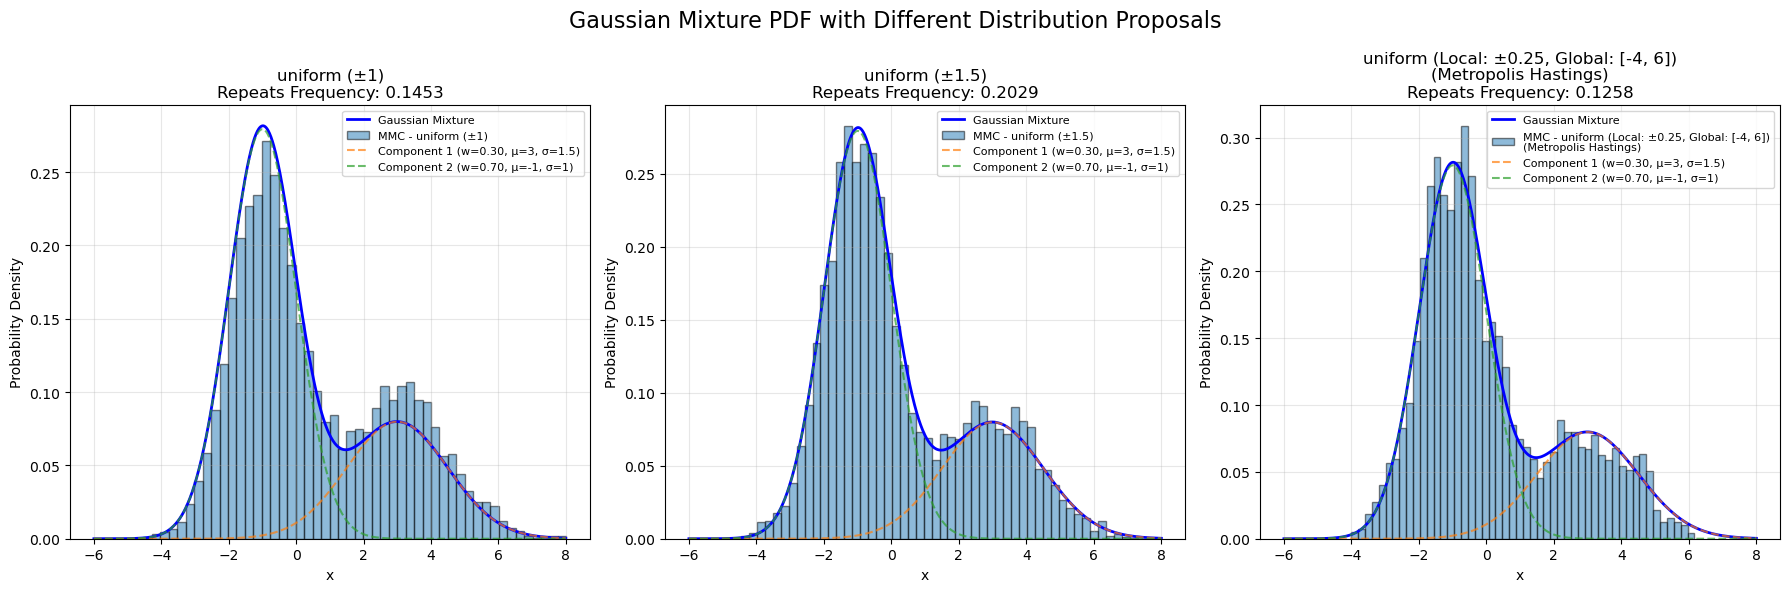

In [11]:
# Create x target pdf values for plotting
x_vals = np.linspace(-6, 8, 1000)
pdf_vals = gaussian_mixture_pdf(x_vals, weights, gaussians)

# Plot the mixture
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
axes = axes.flatten()

for idx, (proposal_dist_name, proposal_dist_info) in enumerate(proposed_dists.items()):
    ax = axes[idx]
    
    # Plot the Gaussian mixture
    ax.plot(x_vals, pdf_vals, 'b-', linewidth=2, label='Gaussian Mixture')
    
    # Get samples and frequency info
    samples = proposal_dist_info['generated_samples']
    repeats_freq = proposal_dist_info['repeats_freq']
    
    # Plot histogram of samples
    ax.hist(samples, bins=50, density=True, alpha=0.5, 
            label=f'MMC - {proposal_dist_name}', edgecolor='black')
    
    # Plot individual components
    for comp_idx, (w, (loc, scale)) in enumerate(zip(weights, gaussians)):
        component_pdf = w * st.norm.pdf(x_vals, loc=loc, scale=scale)
        ax.plot(x_vals, component_pdf, '--', alpha=0.7, 
                label=f'Component {comp_idx+1} (w={w:.2f}, μ={loc}, σ={scale})')
    
    
    # Set labels and title for each subplot
    ax.set_xlabel('x')
    ax.set_ylabel('Probability Density')
    ax.set_title(f'{proposal_dist_name}\nRepeats Frequency: {repeats_freq}')
    
    # Add legend to each subplot
    ax.legend(loc='upper right', fontsize=8)
    ax.grid(True, alpha=0.3)

# Add overall title
fig.suptitle('Gaussian Mixture PDF with Different Distribution Proposals', fontsize=16, y=0.98)
plt.subplots_adjust(top=0.93)

plt.tight_layout()
plt.show()